<a href="https://colab.research.google.com/github/aradjabova/dsc-capstone-project-v2-online-ds-ft-120919/blob/master/aug_then_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import glob
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.models import Sequential, Model
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
import tensorflow as tf
import torch
from tensorflow import keras
import os, os.path
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,recall_score, classification_report, confusion_matrix
from sklearn.utils import class_weight
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, SeparableConv2D, Activation, GaussianNoise, Input, UpSampling2D
from keras import backend as K
from imblearn.over_sampling import SMOTE
from keras.preprocessing import image
from keras import optimizers
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.preprocessing.image import load_img




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
path_train = Path('/content/drive/My Drive/Capstone/Kaggle/seg_train/seg_train')
path_test = Path('/content/drive/My Drive/Capstone/Kaggle/seg_test/seg_test')
path_pred = Path('/content/drive/My Drive/Capstone/Kaggle/seg_pred/seg_pred')

In [0]:
categories = ['buildings','forest','glacier','mountain','sea','street']

# Autoencoded Training Data

In [0]:
def autoencoder():
  input_img = Input(shape=(256,256,3))
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  # x = MaxPooling2D((2, 2), padding='same')(x)
  # x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
  encoded = MaxPooling2D((2, 2), padding='same')(x)

  # x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
  # x = UpSampling2D((2, 2))(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(3, (3, 3), activation='relu', padding='same')(x)

  autoencoder = Model(input_img, decoded)
  autoencoder.compile(optimizer='adam', loss='mse',
                    metrics=['accuracy','mse'])

  return autoencoder

In [0]:
autoencoder = autoencoder()

In [0]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 128, 128, 32)      0   

In [0]:
batch_size = 300

checkpoint = ModelCheckpoint("best_autoencoder.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)


train_datagen = ImageDataGenerator(rescale=1./255, validation_split=.3, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(
        path_train,
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='input')

test_generator = test_datagen.flow_from_directory(
    path_test,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='input')


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [0]:
auto = autoencoder.fit_generator(
    train_generator,
    epochs=10, 
    validation_data=test_generator,
    callbacks=[checkpoint]
    )

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 24 could not be retrieved. It could be because a worker has died.
  UserWarning)


 1/47 [..............................] - ETA: 1:14:59 - loss: 0.2090 - accuracy: 0.1906 - mse: 0.2090

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 26 could not be retrieved. It could be because a worker has died.
  UserWarning)


 2/47 [>.............................] - ETA: 1:01:24 - loss: 0.1695 - accuracy: 0.1999 - mse: 0.1695

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 27 could not be retrieved. It could be because a worker has died.
  UserWarning)


 3/47 [>.............................] - ETA: 56:49 - loss: 0.1621 - accuracy: 0.2042 - mse: 0.1621  

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 14 could not be retrieved. It could be because a worker has died.
  UserWarning)


 4/47 [=>............................] - ETA: 53:10 - loss: 0.1526 - accuracy: 0.2438 - mse: 0.1526

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 25 could not be retrieved. It could be because a worker has died.
  UserWarning)


 5/47 [==>...........................] - ETA: 50:56 - loss: 0.1382 - accuracy: 0.2600 - mse: 0.1382

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 31 could not be retrieved. It could be because a worker has died.
  UserWarning)


 6/47 [==>...........................] - ETA: 49:36 - loss: 0.1232 - accuracy: 0.2578 - mse: 0.1232

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 16 could not be retrieved. It could be because a worker has died.
  UserWarning)


 7/47 [===>..........................] - ETA: 47:42 - loss: 0.1106 - accuracy: 0.2644 - mse: 0.1106

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 2 could not be retrieved. It could be because a worker has died.
  UserWarning)


 8/47 [====>.........................] - ETA: 45:46 - loss: 0.1009 - accuracy: 0.2844 - mse: 0.1009

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 41 could not be retrieved. It could be because a worker has died.
  UserWarning)


10/47 [=====>........................] - ETA: 41:50 - loss: 0.0904 - accuracy: 0.3110 - mse: 0.0913

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 22 could not be retrieved. It could be because a worker has died.
  UserWarning)


11/47 [======>.......................] - ETA: 40:57 - loss: 0.0858 - accuracy: 0.3249 - mse: 0.0865

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 18 could not be retrieved. It could be because a worker has died.
  UserWarning)


12/47 [======>.......................] - ETA: 39:39 - loss: 0.0814 - accuracy: 0.3361 - mse: 0.0820

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 36 could not be retrieved. It could be because a worker has died.
  UserWarning)


13/47 [=======>......................] - ETA: 38:36 - loss: 0.0774 - accuracy: 0.3440 - mse: 0.0778

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 28 could not be retrieved. It could be because a worker has died.
  UserWarning)


14/47 [=======>......................] - ETA: 37:51 - loss: 0.0738 - accuracy: 0.3503 - mse: 0.0741

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 19 could not be retrieved. It could be because a worker has died.
  UserWarning)


15/47 [========>.....................] - ETA: 37:01 - loss: 0.0705 - accuracy: 0.3546 - mse: 0.0709

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 7 could not be retrieved. It could be because a worker has died.
  UserWarning)


16/47 [=========>....................] - ETA: 35:54 - loss: 0.0676 - accuracy: 0.3477 - mse: 0.0679

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 13 could not be retrieved. It could be because a worker has died.
  UserWarning)


17/47 [=========>....................] - ETA: 34:51 - loss: 0.0652 - accuracy: 0.3414 - mse: 0.0654

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 38 could not be retrieved. It could be because a worker has died.
  UserWarning)


18/47 [==========>...................] - ETA: 33:36 - loss: 0.0630 - accuracy: 0.3378 - mse: 0.0631

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 11 could not be retrieved. It could be because a worker has died.
  UserWarning)


19/47 [===========>..................] - ETA: 32:20 - loss: 0.0610 - accuracy: 0.3358 - mse: 0.0611

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 29 could not be retrieved. It could be because a worker has died.
  UserWarning)


20/47 [===========>..................] - ETA: 31:10 - loss: 0.0593 - accuracy: 0.3347 - mse: 0.0594

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 37 could not be retrieved. It could be because a worker has died.
  UserWarning)


21/47 [============>.................] - ETA: 30:05 - loss: 0.0576 - accuracy: 0.3337 - mse: 0.0576

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 15 could not be retrieved. It could be because a worker has died.
  UserWarning)


22/47 [=============>................] - ETA: 29:25 - loss: 0.0560 - accuracy: 0.3307 - mse: 0.0561

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 3 could not be retrieved. It could be because a worker has died.
  UserWarning)


23/47 [=============>................] - ETA: 28:09 - loss: 0.0545 - accuracy: 0.3280 - mse: 0.0546

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 5 could not be retrieved. It could be because a worker has died.
  UserWarning)


24/47 [==============>...............] - ETA: 26:52 - loss: 0.0531 - accuracy: 0.3239 - mse: 0.0531

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 23 could not be retrieved. It could be because a worker has died.
  UserWarning)


25/47 [==============>...............] - ETA: 25:39 - loss: 0.0518 - accuracy: 0.3281 - mse: 0.0518

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 30 could not be retrieved. It could be because a worker has died.
  UserWarning)


26/47 [===============>..............] - ETA: 24:23 - loss: 0.0506 - accuracy: 0.3343 - mse: 0.0506

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 40 could not be retrieved. It could be because a worker has died.
  UserWarning)


27/47 [================>.............] - ETA: 23:11 - loss: 0.0495 - accuracy: 0.3398 - mse: 0.0495

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 44 could not be retrieved. It could be because a worker has died.
  UserWarning)


28/47 [================>.............] - ETA: 21:59 - loss: 0.0484 - accuracy: 0.3462 - mse: 0.0484

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 17 could not be retrieved. It could be because a worker has died.
  UserWarning)


29/47 [=================>............] - ETA: 20:53 - loss: 0.0474 - accuracy: 0.3532 - mse: 0.0474

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 0 could not be retrieved. It could be because a worker has died.
  UserWarning)


30/47 [==================>...........] - ETA: 19:41 - loss: 0.0464 - accuracy: 0.3625 - mse: 0.0464

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 35 could not be retrieved. It could be because a worker has died.
  UserWarning)


31/47 [==================>...........] - ETA: 18:33 - loss: 0.0455 - accuracy: 0.3725 - mse: 0.0455

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 34 could not be retrieved. It could be because a worker has died.
  UserWarning)


32/47 [===================>..........] - ETA: 17:25 - loss: 0.0446 - accuracy: 0.3795 - mse: 0.0446

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 43 could not be retrieved. It could be because a worker has died.
  UserWarning)


33/47 [====================>.........] - ETA: 16:15 - loss: 0.0437 - accuracy: 0.3801 - mse: 0.0437

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 9 could not be retrieved. It could be because a worker has died.
  UserWarning)


34/47 [====================>.........] - ETA: 15:03 - loss: 0.0429 - accuracy: 0.3809 - mse: 0.0429

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 10 could not be retrieved. It could be because a worker has died.
  UserWarning)


35/47 [=====================>........] - ETA: 13:51 - loss: 0.0421 - accuracy: 0.3838 - mse: 0.0421

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 6 could not be retrieved. It could be because a worker has died.
  UserWarning)


38/47 [=======================>......] - ETA: 10:06 - loss: 0.0399 - accuracy: 0.4055 - mse: 0.0398

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 45 could not be retrieved. It could be because a worker has died.
  UserWarning)


39/47 [=======================>......] - ETA: 8:58 - loss: 0.0392 - accuracy: 0.4119 - mse: 0.0392 

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 42 could not be retrieved. It could be because a worker has died.
  UserWarning)


40/47 [========================>.....] - ETA: 7:52 - loss: 0.0386 - accuracy: 0.4187 - mse: 0.0385

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 33 could not be retrieved. It could be because a worker has died.
  UserWarning)


41/47 [=========================>....] - ETA: 6:45 - loss: 0.0379 - accuracy: 0.4253 - mse: 0.0379

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 39 could not be retrieved. It could be because a worker has died.
  UserWarning)


42/47 [=========================>....] - ETA: 5:38 - loss: 0.0373 - accuracy: 0.4304 - mse: 0.0373

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 4 could not be retrieved. It could be because a worker has died.
  UserWarning)


43/47 [==========================>...] - ETA: 4:30 - loss: 0.0368 - accuracy: 0.4352 - mse: 0.0367

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 12 could not be retrieved. It could be because a worker has died.
  UserWarning)


44/47 [===========================>..] - ETA: 3:22 - loss: 0.0362 - accuracy: 0.4398 - mse: 0.0361

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 1 could not be retrieved. It could be because a worker has died.
  UserWarning)


45/47 [===========================>..] - ETA: 2:15 - loss: 0.0357 - accuracy: 0.4449 - mse: 0.0356

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 20 could not be retrieved. It could be because a worker has died.
  UserWarning)


46/47 [============================>.] - ETA: 1:07 - loss: 0.0351 - accuracy: 0.4501 - mse: 0.0351

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 32 could not be retrieved. It could be because a worker has died.
  UserWarning)


47/47 [==============================] - 3181s 68s/step - loss: 0.0346 - accuracy: 0.4553 - mse: 0.0346 - val_loss: 0.0113 - val_accuracy: 0.6940 - val_mse: 0.0115

Epoch 00001: loss improved from inf to 0.03457, saving model to best_autoencoder.hdf5
Epoch 2/10
47/47 [==============================] - 1171s 25s/step - loss: 0.0095 - accuracy: 0.7319 - mse: 0.0095 - val_loss: 0.0084 - val_accuracy: 0.7585 - val_mse: 0.0083

Epoch 00002: loss improved from 0.03457 to 0.00948, saving model to best_autoencoder.hdf5
Epoch 3/10
47/47 [==============================] - 1197s 25s/step - loss: 0.0076 - accuracy: 0.7766 - mse: 0.0076 - val_loss: 0.0069 - val_accuracy: 0.7892 - val_mse: 0.0070

Epoch 00003: loss improved from 0.00948 to 0.00755, saving model to best_autoencoder.hdf5
Epoch 4/10
47/47 [==============================] - 1182s 25s/step - loss: 0.0068 - accuracy: 0.7888 - mse: 0.0068 - val_loss: 0.0064 - val_accuracy: 0.8054 - val_mse: 0.0065

Epoch 00004: loss improved from 0.00755 t

In [0]:
autoencoder.evaluate_generator(test_generator)

[0.005446318071335554, 0.8230494260787964, 0.005013676360249519]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


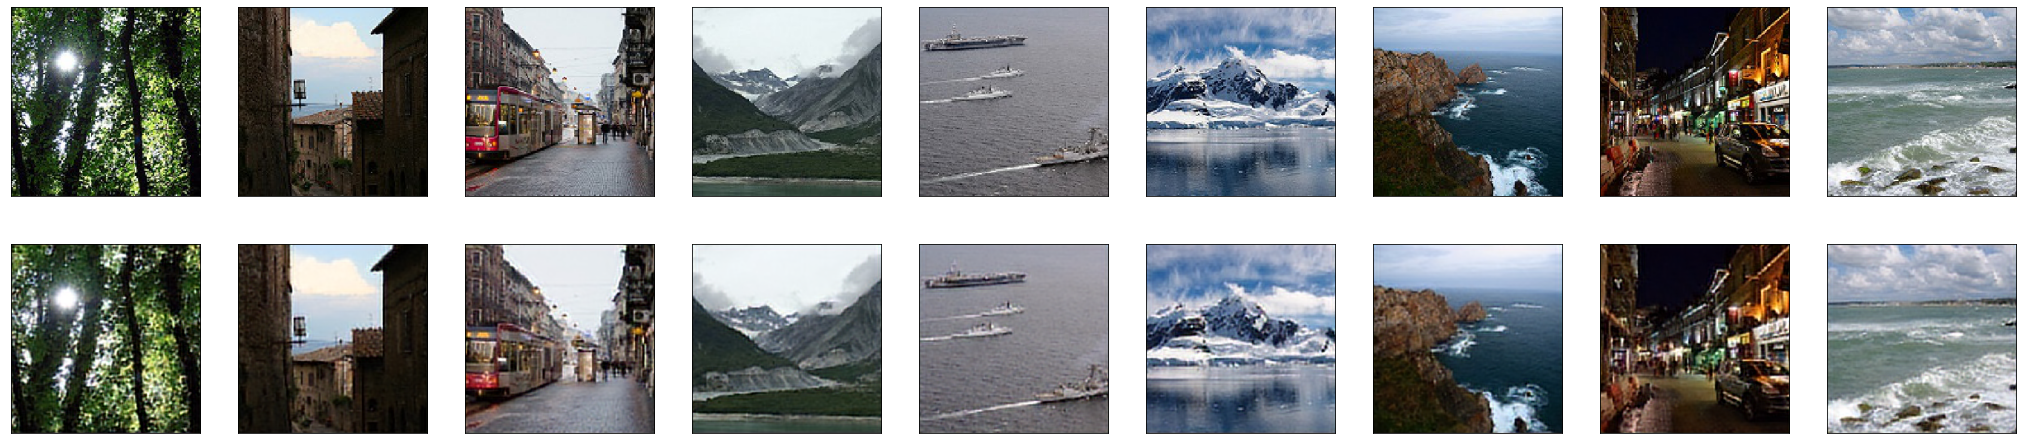

In [0]:
x_test, y_test = test_generator.next()
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(40, 8))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()



In [0]:
model_save_name = 'autoencoder.pt'
path = F"/content/drive/My Drive/Capstone/Notebooks/{model_save_name}" 
torch.save(autoencoder, path)

In [0]:
model_save_name = 'autoencoder_weights.pt'
path = F"/content/drive/My Drive/Capstone/Notebooks/{model_save_name}" 
torch.save(autoencoder.weights, path)

# CNN of autoencoded data


In [0]:
y_train_label = train_generator.labels
y_test_label = test_generator.labels

In [0]:
x_train_img_aug = autoencoder.predict_generator(train_generator)

In [0]:

x_test_aug = autoencoder.predict_generator(test_generator)

In [0]:
def simple_cnn():
  input_shape = (256, 256, 3)
  model = Sequential()
  model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  # model.add(Conv2D(16, (3,3), activation='relu'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(8, (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(6,activation='softmax'))

  model.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

  return model

In [0]:
model = simple_cnn()

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 8)       2312      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 30752)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3936384   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [0]:

# batch_size=200

checkpoint = ModelCheckpoint("best_model.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

In [0]:
train = model.fit(x_train_img_aug, y_train_label,
                  epochs=10,
                  shuffle=True,
                  batch_size=batch_size,
                  callbacks=[checkpoint],
                  validation_data=(x_test_aug, y_test_label))

Train on 14034 samples, validate on 3000 samples
Epoch 1/10
14034/14034 [==============================] - 156s 11ms/step - loss: 1.8196 - accuracy: 0.1763 - val_loss: 1.7912 - val_accuracy: 0.1727

Epoch 00001: loss improved from inf to 1.81956, saving model to best_model.hdf5
Epoch 2/10
14034/14034 [==============================] - 150s 11ms/step - loss: 1.7888 - accuracy: 0.1863 - val_loss: 1.7910 - val_accuracy: 0.1733

Epoch 00002: loss improved from 1.81956 to 1.78878, saving model to best_model.hdf5
Epoch 3/10
14034/14034 [==============================] - 149s 11ms/step - loss: 1.7725 - accuracy: 0.2187 - val_loss: 1.8016 - val_accuracy: 0.1670

Epoch 00003: loss improved from 1.78878 to 1.77255, saving model to best_model.hdf5
Epoch 4/10
14034/14034 [==============================] - 149s 11ms/step - loss: 1.6913 - accuracy: 0.2916 - val_loss: 1.8537 - val_accuracy: 0.1700

Epoch 00004: loss improved from 1.77255 to 1.69131, saving model to best_model.hdf5
Epoch 5/10
14034/14

In [0]:
model.evaluate(x_test_aug, y_test_label)

3000/3000 [==============================] - 4s 1ms/step


[4.281877937316895, 0.1653333306312561]

In [0]:
pred = model.predict(x_test_aug)
pred = np.argmax(pred, axis=1)

In [0]:
accuracy=train.history['accuracy']
val_acc=train.history['val_accuracy']
loss=train.history['loss']
val_loss=train.history['val_loss']
epochs=list(range(10))


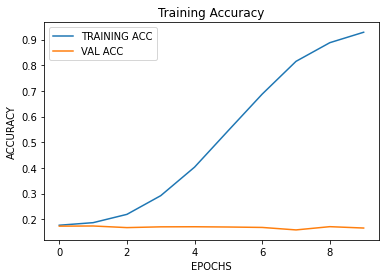

In [0]:
import matplotlib.pyplot as plt
plt.plot(epochs,accuracy)
plt.title('Training Accuracy')
plt.xlabel('EPOCHS')
plt.ylabel('ACCURACY')
plt.plot(epochs,val_acc)
plt.legend(['TRAINING ACC','VAL ACC'])
plt.show()

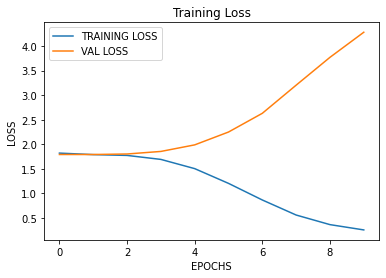

In [0]:
plt.plot(epochs,loss)
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.plot(epochs,val_loss)
plt.legend(['TRAINING LOSS','VAL LOSS']) 
plt.title('Training Loss')
plt.show()

In [0]:
print(classification_report(y_test_label, pred))

              precision    recall  f1-score   support

           0       0.15      0.15      0.15       437
           1       0.17      0.17      0.17       474
           2       0.19      0.17      0.18       553
           3       0.16      0.22      0.18       525
           4       0.18      0.14      0.15       510
           5       0.16      0.14      0.15       501

    accuracy                           0.17      3000
   macro avg       0.17      0.16      0.16      3000
weighted avg       0.17      0.17      0.16      3000



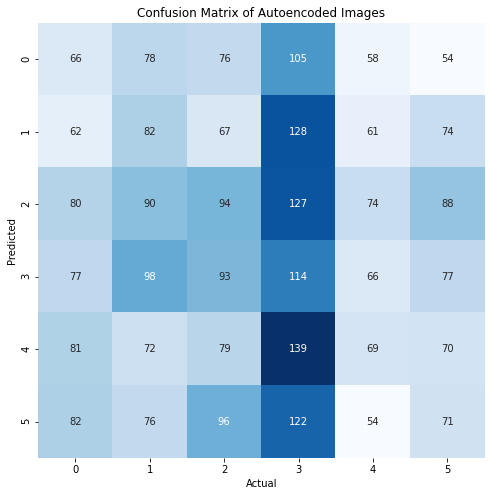

In [0]:
cm = confusion_matrix(y_test_label, pred)
plt.figure(figsize=(8,8))
sns.heatmap(cm, cmap="Blues", annot=True, fmt='.3g', cbar=False)
plt.title('Confusion Matrix of Autoencoded Images')
plt.xlabel('Actual')
plt.ylabel("Predicted")
plt.show()

In [0]:
recall_score(y_test_label, pred, average='micro')

0.16533333333333333